In [1]:
import numpy as np # linear algebra
import pandas as pd

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()
sns.set()

%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from funcs import correct_macro_df, get_corr_empty_info, prepare_choosed_features

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
# train_df = pd.read_csv("data/train.csv")

# macro_df = pd.read_csv("data/macro.csv")
# macro_df['date'] = pd.to_datetime(macro_df['timestamp'])

train_df = pd.read_csv("data/train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("data/test.csv", parse_dates=['timestamp'])
macro_df = pd.read_csv("data/macro.csv", parse_dates=['timestamp'])

macro_df = correct_macro_df(macro_df=macro_df)

train_df = pd.merge(train_df, macro_df, how='left', on='timestamp', suffixes=['macro_',''])
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp', suffixes=['macro_',''])
print(train_df.shape, test_df.shape)

# truncate the extreme values in price_doc #
# ulimit = np.percentile(train_df.price_doc.values, 99)
# llimit = np.percentile(train_df.price_doc.values, 1)
# train_df['price_doc'].ix[train_df['price_doc']>ulimit] = ulimit
# train_df['price_doc'].ix[train_df['price_doc']<llimit] = llimit

(30471, 391) (7662, 390)


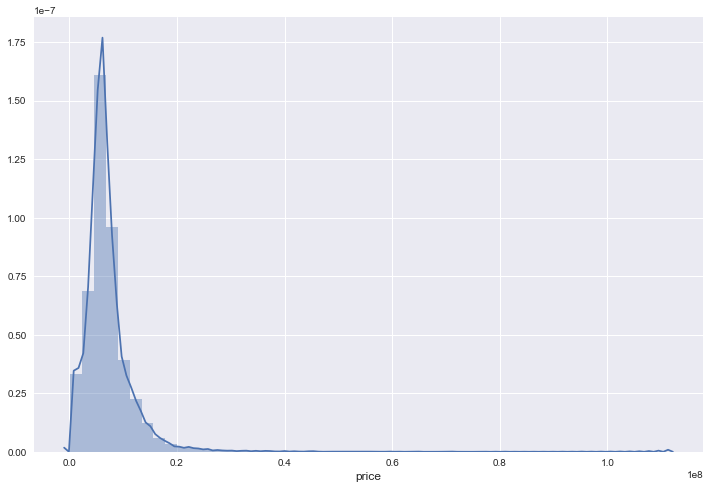

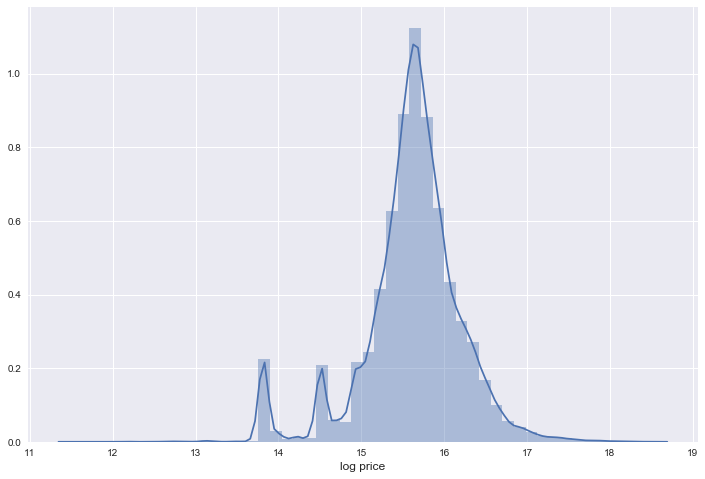

In [3]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

plt.figure(figsize=(12,8))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('log price', fontsize=12)
plt.show()

Text(0.5,0,'% missing')

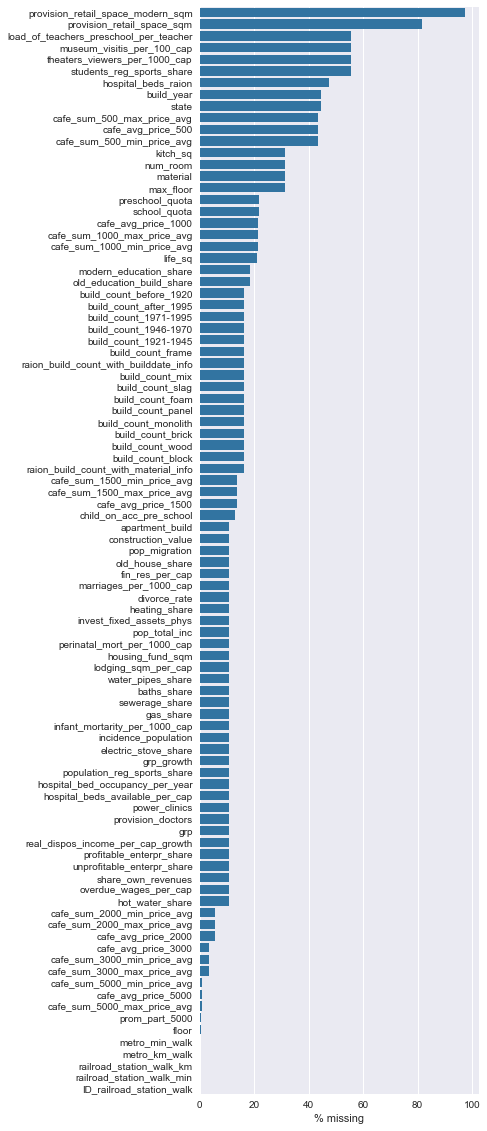

In [4]:
fig = plt.figure(figsize=(5,20))
train_na = (train_df.isnull().sum() / len(train_df)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
sns.barplot(y=train_na.index, x=train_na, color=color[0])
plt.xlabel('% missing')

In [5]:
train_df["build_count_before_1945"] = train_df["build_count_before_1920"] + train_df["build_count_1921-1945"]
train_df["build_count_wood_slag"] = train_df['build_count_wood'] + train_df['build_count_slag']
train_df['female_male_diff'] = train_df['female_f'] - train_df['male_f']
train_df['young_female_male_diff'] = train_df['young_female'] - train_df['young_male']

In [6]:
USE_FEATURES = [
    "full_sq", "life_sq", "kitch_sq", "num_room",
    "floor", "max_floor", 
    "build_year", "timestamp",
    "product_type", "state", "material", 
    "sub_area",
    'lodging_sqm_per_cap'
]

##########################################################
                         prct_non_empty        col_type
full_sq                             1.0           int64
life_sq              0.7905221358012536         float64
kitch_sq             0.6858652489252076         float64
num_room             0.6858652489252076         float64
floor                0.9945193790817498         float64
max_floor            0.6858652489252076         float64
build_year           0.5535098946539333         float64
timestamp                           1.0  datetime64[ns]
product_type                        1.0          object
state                0.5550195267631518         float64
material             0.6858652489252076         float64
sub_area                            1.0          object
lodging_sqm_per_cap   0.893702208657412         float64
##########################################################


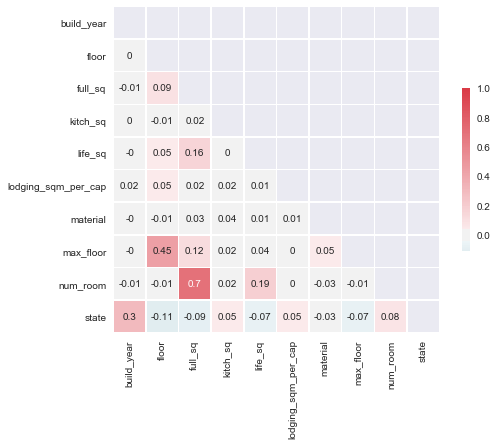

In [7]:
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=USE_FEATURES)

##########################################################
                           prct_non_empty col_type
build_count_block      0.8362049161497818  float64
build_count_frame      0.8362049161497818  float64
build_count_brick      0.8362049161497818  float64
build_count_monolith   0.8362049161497818  float64
build_count_panel      0.8362049161497818  float64
build_count_foam       0.8362049161497818  float64
build_count_wood_slag  0.8362049161497818  float64
##########################################################


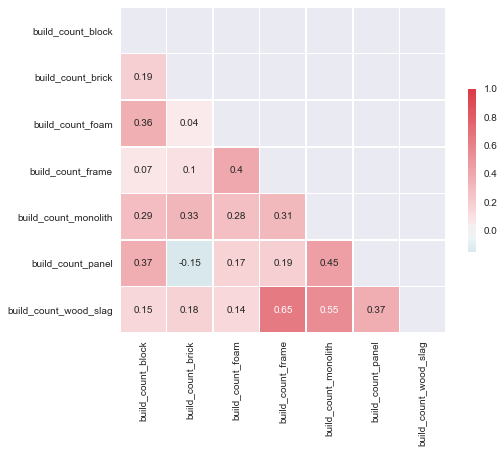

In [8]:
cols = [
#     'raion_build_count_with_material_info',
#     'raion_build_count_with_builddate_info',
#     'build_count_wood',
#     'build_count_slag',
    'build_count_block',
    'build_count_frame',
    'build_count_brick',
    'build_count_monolith',
    'build_count_panel',
    'build_count_foam',
    "build_count_wood_slag",
#     'build_count_mix',
#     'build_count_before_1920',
#     'build_count_1921-1945',
#     "build_count_before_1945",
#     'build_count_1946-1970',
#     'build_count_1971-1995',
#     'build_count_after_1995'
]
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=cols)

In [9]:
# USE_FEATURES += ['build_count_block',
#                  'build_count_frame',
#                  'build_count_brick',
#                  'build_count_monolith',
#                  'build_count_panel',
#                  'build_count_foam',
#                  "build_count_wood_slag"]
USE_FEATURES += cols

##########################################################
                prct_non_empty col_type
green_part_500             1.0  float64
green_zone_km              1.0  float64
green_zone_part            1.0  float64
prom_part_500              1.0  float64
prom_part_2000             1.0  float64
##########################################################


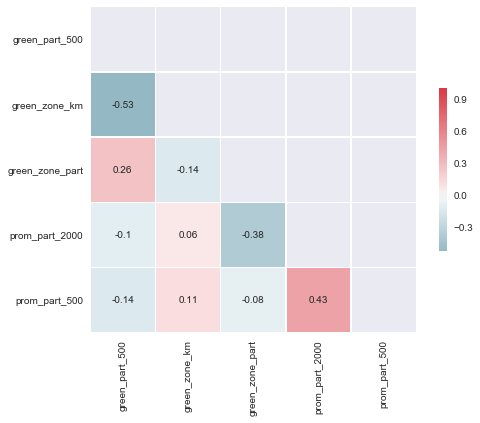

In [10]:
cols = [
    'green_part_500',
    'green_zone_km',
    'green_zone_part',
    'prom_part_500',
#     'green_part_1000',
#     'prom_part_1000',
#     'green_part_1500',
#     'prom_part_1500',
#     'green_part_2000',
    'prom_part_2000',
#     'green_part_3000',
#     'prom_part_3000',
#     'green_part_5000',
#     'prom_part_5000'
]
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=cols)

In [11]:
# USE_FEATURES += ['green_part_500',
#                  'green_zone_part',
#                  'green_zone_km',
#                  'prom_part_500',
#                  'prom_part_2000']
USE_FEATURES += cols

##########################################################
                           prct_non_empty col_type
office_count_500                      1.0    int64
cafe_count_1000_price_high            1.0    int64
mosque_count_1000                     1.0    int64
leisure_count_500                     1.0    int64
sport_count_500                       1.0    int64
market_count_500                      1.0    int64
trc_count_3000                        1.0    int64
railroad_station_avto_km              1.0  float64
mkad_km                               1.0  float64
sadovoe_km                            1.0  float64
oil_chemistry_raion                   1.0   object
oil_chemistry_km                      1.0  float64
full_all                              1.0    int64
young_all                             1.0    int64
young_female_male_diff                1.0    int64
##########################################################


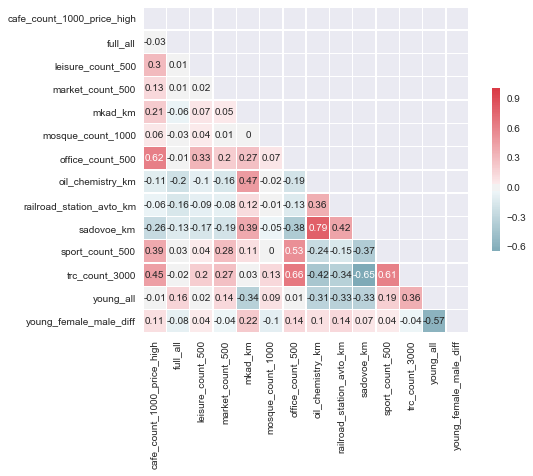

In [12]:
cols = [
    'office_count_500',
#     'trc_count_500',
#     'cafe_count_500',
#     'cafe_count_500_na_price',
#     'cafe_count_500_price_500',
#     'cafe_count_500_price_1000',
#     'cafe_count_500_price_1500',
#     'cafe_count_500_price_2500',
#     'cafe_count_500_price_4000',
    'cafe_count_1000_price_high',
#     'big_church_count_500',
#     'church_count_500',
    'mosque_count_1000',
    'leisure_count_500',
    'sport_count_500',
    'market_count_500',
    'trc_count_3000',
#     'cafe_count_1500_price_high',
#     'metro_km_walk',
    'railroad_station_avto_km',
#     'railroad_station_avto_min',
#     'zd_vokzaly_avto_km',
#     'bus_terminal_avto_km',
    'mkad_km',
#     'ttk_km',
    'sadovoe_km',
#     'ts_km',
    'oil_chemistry_raion',
    'oil_chemistry_km',
#     'kremlin_km',
    'full_all',
#     'female_male_diff'
    'young_all',
    'young_female_male_diff',
#     'work_all', 'work_male', 'work_female'
#     'ekder_all',
#     'ekder_male', 'ekder_female',
]
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=cols)

In [13]:
# USE_FEATURES += ['cafe_count_1000_price_high',
#                  'mosque_count_1000',
#                  'office_count_500',
#                  'leisure_count_500',
#                  'sport_count_500',
#                  'market_count_500',
#                  'trc_count_3000',
#                  'metro_km_walk']
USE_FEATURES += cols

In [17]:
list(filter(lambda x: "_km" in x, train_df.columns.tolist()))

['metro_km_avto',
 'metro_km_walk',
 'kindergarten_km',
 'school_km',
 'park_km',
 'green_zone_km',
 'industrial_km',
 'water_treatment_km',
 'cemetery_km',
 'incineration_km',
 'railroad_station_walk_km',
 'railroad_station_avto_km',
 'public_transport_station_km',
 'water_km',
 'mkad_km',
 'ttk_km',
 'sadovoe_km',
 'bulvar_ring_km',
 'kremlin_km',
 'big_road1_km',
 'big_road2_km',
 'railroad_km',
 'zd_vokzaly_avto_km',
 'bus_terminal_avto_km',
 'oil_chemistry_km',
 'nuclear_reactor_km',
 'radiation_km',
 'power_transmission_line_km',
 'thermal_power_plant_km',
 'ts_km',
 'big_market_km',
 'market_shop_km',
 'fitness_km',
 'swim_pool_km',
 'ice_rink_km',
 'stadium_km',
 'basketball_km',
 'hospice_morgue_km',
 'detention_facility_km',
 'public_healthcare_km',
 'university_km',
 'workplaces_km',
 'shopping_centers_km',
 'office_km',
 'additional_education_km',
 'preschool_km',
 'big_church_km',
 'church_synagogue_km',
 'mosque_km',
 'theater_km',
 'museum_km',
 'exhibition_km',
 'cateri

In [21]:
train_df[sorted(cols)].head(15)

,green_part_2000,green_part_500,prom_part_2000,prom_part_500
0,11.77,0.00,15.97,0.00
1,22.37,25.14,19.25,0.00
2,12.99,1.67,12.75,0.00
3,32.29,17.36,5.73,0.57
4,4.53,3.56,5.02,4.44
5,0.38,0.00,51.58,19.42
6,23.45,0.00,5.25,0.00
7,15.02,17.62,7.13,0.00
8,22.00,7.71,19.72,0.00
9,20.47,33.79,0.00,0.00


In [14]:
train_df_processed = prepare_choosed_features(train_df, USE_FEATURES,
                                              dont_touch_cols=["build_year", "timestamp", "material", "max_floor"])

def manual_processing(df):
    df = df.copy()
    
    df["material0"] = df.material.isnull().astype(int)
    df["material1"] = (df.material==1).astype(int)
    df["material2"] = (df.material==2).astype(int)
    df["material3"] = (df.material==3).astype(int)
    df["material4"] = (df.material==4).astype(int)
    df["material5"] = (df.material==5).astype(int)
    df["material6"] = (df.material==6).astype(int)
    del df["material"]
    
    df["build0"] = (df.build_year==0).astype(int)
    df["build1"] = (df.build_year==1).astype(int)
    df.loc[df.build_year>2030,"build_year"] = np.NaN
    df.loc[df.build_year<1600,"build_year"] = np.NaN
    df["nobuild"] = df.build_year.isnull().astype(int)
    df["transaction_since_build"] = pd.to_datetime(df.timestamp).dt.year - df.build_year
    df.build_year = df.build_year.fillna(df.build_year.mode().values[0])
    df.transaction_since_build = df.transaction_since_build.fillna(df.transaction_since_build.median())
    
    df["floor0"] = (df.floor==0).astype(int)
    df["floor1"] = (df.floor==1).astype(int)
    df["floorhuge"] = (df.floor>40).astype(int)
#    df["lnfloor"] = np.log(df.floor+1)

    df["nomax_floor"] = df.max_floor.isnull().astype(int)
    df.max_floor = df.max_floor.fillna(df.max_floor.median())
    df["max0"] = (df.max_floor==0).astype(int)
    df["max1"] = (df.max_floor==1).astype(int)
    df["maxhuge"] = (df.max_floor>80).astype(int)
#    df["lnmax"] = np.log(df.max_floor+1)
    
    return df

Processing column: full_sq
Processing column: life_sq
Processing column: kitch_sq
Processing column: num_room
Processing column: floor
Processing column: max_floor
Processing column: build_year
Processing column: timestamp
Processing column: product_type
Processing column: state
Processing column: material
Processing column: sub_area
Processing column: lodging_sqm_per_cap
Processing column: build_count_block
Processing column: build_count_frame
Processing column: build_count_brick
Processing column: build_count_monolith
Processing column: build_count_panel
Processing column: build_count_foam
Processing column: build_count_wood_slag
Processing column: green_part_500
Processing column: green_zone_km
Processing column: green_zone_part
Processing column: prom_part_500
Processing column: prom_part_2000
Processing column: office_count_500
Processing column: cafe_count_1000_price_high
Processing column: mosque_count_1000
Processing column: leisure_count_500
Processing column: sport_count_500


In [15]:
train_df_processed = manual_processing(train_df_processed)

In [18]:
# cols=["full_sq", "life_sq", "kitch_sq", "num_room",
#       "floor", "max_floor", 
#       "build_year", "transaction_since_build",
#       "maxhuge", "nomax_floor", "floor0", "floor1", "floorhuge"]

# cols = ["cafe_count_5000_na_price", "cafe_count_5000_price_500", "cafe_count_5000_price_1000", "cafe_count_5000_price_1500", 
#         "cafe_count_5000_price_2500", "cafe_count_5000_price_4000", "cafe_count_5000_price_high", 
#         "cafe_count_500_na_price", "cafe_count_500_price_500", "cafe_count_500_price_1000", "cafe_count_500_price_1500", 
#         "cafe_count_500_price_2500", "cafe_count_500_price_4000", "cafe_count_500_price_high"]

# corr_df_proc, empty_info_proc = get_corr_empty_info(df=train_df_processed, cols=cols)

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

X = train_df_processed.copy()
del X["timestamp"]
Y = train_df.price_doc.apply(np.log)

def rmsle_exp(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return np.sqrt(np.mean(np.power(np.log(y_true + 1) - np.log(y_pred + 1), 2)))


cv = KFold(n_splits=5, random_state=123, shuffle=True)

model = XGBRegressor()

for (train, test), i in zip(cv.split(X, Y), range(5)):
    model.fit(X.iloc[train], Y.iloc[train])
    pred_train = model.predict(X.iloc[train])
    pred_test = model.predict(X.iloc[test])
    
    print("train RMSLE:", rmsle_exp(Y.iloc[train], pred_train))
    print("test RMSLE:", rmsle_exp(Y.iloc[test], pred_test))
    print("-----------------------------")

train RMSLE: 0.45310992639962133
test RMSLE: 0.4805517129334744
-----------------------------
train RMSLE: 0.45733211519662265
test RMSLE: 0.4575533625776208
-----------------------------
train RMSLE: 0.4598500652590845
test RMSLE: 0.4523385459791822
-----------------------------
train RMSLE: 0.4545483424693628
test RMSLE: 0.46643724582296764
-----------------------------
train RMSLE: 0.4534501784770783
test RMSLE: 0.47377465038604877
-----------------------------


In [21]:
X.columns.tolist()

['full_sq',
 'life_sq',
 'kitch_sq',
 'num_room',
 'floor',
 'max_floor',
 'build_year',
 'product_type_Investment',
 'state',
 'sub_area_Ajeroport',
 'sub_area_Akademicheskoe',
 'sub_area_Alekseevskoe',
 "sub_area_Altuf'evskoe",
 'sub_area_Arbat',
 'sub_area_Babushkinskoe',
 'sub_area_Basmannoe',
 'sub_area_Begovoe',
 'sub_area_Beskudnikovskoe',
 'sub_area_Bibirevo',
 'sub_area_Birjulevo Vostochnoe',
 'sub_area_Birjulevo Zapadnoe',
 'sub_area_Bogorodskoe',
 'sub_area_Brateevo',
 'sub_area_Butyrskoe',
 'sub_area_Caricyno',
 'sub_area_Cheremushki',
 "sub_area_Chertanovo Central'noe",
 'sub_area_Chertanovo Juzhnoe',
 'sub_area_Chertanovo Severnoe',
 'sub_area_Danilovskoe',
 'sub_area_Dmitrovskoe',
 'sub_area_Donskoe',
 'sub_area_Dorogomilovo',
 'sub_area_Filevskij Park',
 'sub_area_Fili Davydkovo',
 'sub_area_Gagarinskoe',
 "sub_area_Gol'janovo",
 'sub_area_Golovinskoe',
 'sub_area_Hamovniki',
 'sub_area_Horoshevo-Mnevniki',
 'sub_area_Horoshevskoe',
 'sub_area_Hovrino',
 'sub_area_Ivano

In [ ]:
# dfa["fullzero"] = (dfa.full_sq==0)
# dfa["fulltiny"] = (dfa.full_sq<4)
# dfa["fullhuge"] = (dfa.full_sq>2000)
# dfa["lnfull"] = np.log(dfa.full_sq+1)

# dfa["nolife"] = dfa.life_sq.isnull()
# dfa.life_sq = dfa.life_sq.fillna(dfa.life_sq.median())
# dfa["lifezero"] = (dfa.life_sq==0)
# dfa["lifetiny"] = (dfa.life_sq<4)
# dfa["lifehuge"] = (dfa.life_sq>2000)
# dfa["lnlife"] = np.log( dfa.life_sq + 1 )



# dfa["norooms"] = dfa.num_room.isnull()
# dfa.num_room = dfa.num_room.fillna(dfa.num_room.median())
# dfa["zerorooms"] = (dfa.num_room==0)
# dfa["lnrooms"] = np.log( dfa.num_room + 1 )

# dfa["nokitch"] = dfa.kitch_sq.isnull()
# dfa.kitch_sq = dfa.kitch_sq.fillna(dfa.kitch_sq.median())
# dfa["kitch1"] = (dfa.kitch_sq==1)
# dfa["kitch0"] = (dfa.kitch_sq==0)
# dfa["kitchhuge"] = (dfa.kitch_sq>400)
# dfa["lnkitch"] = np.log(dfa.kitch_sq+1)

# # "state" isn't explained but it looks like an ordinal number, so for now keep numeric
# dfa.loc[dfa.state>5,"state"] = np.NaN  # Value 33 seems to be invalid; others all 1-4
# dfa.state = dfa.state.fillna(dfa.state.median())

# # product_type gonna be ugly because there are missing values in the test set but not training
# # Check for the same problem with other variables
# dfa["owner_occ"] = (dfa.product_type=='OwnerOccupier')
# dfa.owner_occ.fillna(dfa.owner_occ.mean())


# # Interaction terms
# dfa["fullzero_Xowner"] = dfa.fullzero.astype("float64") * dfa.owner_occ
# dfa["fulltiny_Xowner"] = dfa.fulltiny.astype("float64") * dfa.owner_occ
# dfa["fullhuge_Xowner"] = dfa.fullhuge.astype("float64") * dfa.owner_occ
# dfa["lnfull_Xowner"] = dfa.lnfull * dfa.owner_occ
# dfa["nofloor_Xowner"] = dfa.nofloor.astype("float64") * dfa.owner_occ
# dfa["floor0_Xowner"] = dfa.floor0.astype("float64") * dfa.owner_occ
# dfa["floor1_Xowner"] = dfa.floor1.astype("float64") * dfa.owner_occ
# dfa["lnfloor_Xowner"] = dfa.lnfloor * dfa.owner_occ
# dfa["max1_Xowner"] = dfa.max1.astype("float64") * dfa.owner_occ
# dfa["max0_Xowner"] = dfa.max0.astype("float64") * dfa.owner_occ
# dfa["maxhuge_Xowner"] = dfa.maxhuge.astype("float64") * dfa.owner_occ
# dfa["lnmax_Xowner"] = dfa.lnmax * dfa.owner_occ
# dfa["kitch1_Xowner"] = dfa.kitch1.astype("float64") * dfa.owner_occ
# dfa["kitch0_Xowner"] = dfa.kitch0.astype("float64") * dfa.owner_occ
# dfa["kitchhuge_Xowner"] = dfa.kitchhuge.astype("float64") * dfa.owner_occ
# dfa["lnkitch_Xowner"] = dfa.lnkitch * dfa.owner_occ
# dfa["nobuild_Xowner"] = dfa.nobuild.astype("float64") * dfa.owner_occ
# dfa["newhouse_Xowner"] = dfa.newhouse.astype("float64") * dfa.owner_occ
# dfa["tooold_Xowner"] = dfa.tooold.astype("float64") * dfa.owner_occ
# dfa["build0_Xowner"] = dfa.build0.astype("float64") * dfa.owner_occ
# dfa["build1_Xowner"] = dfa.build1.astype("float64") * dfa.owner_occ
# dfa["lnsince_Xowner"] = dfa.lnsince * dfa.owner_occ
# dfa["state_Xowner"] = dfa.state * dfa.owner_occ